
# Ciencia de Datos — ETL + EDA con Datos Reales  
## **API Banco Mundial (Ecuador, Colombia, Perú)**  
### Notebook completamente comentado y explicado paso a paso

Este notebook fue creado para enseñar **Ciencia de Datos desde cero**, mostrando:

✔ Cómo conectarse a una **API real** (Banco Mundial)  
✔ Cómo realizar un proceso **ETL (Extract – Transform – Load)**  
✔ Cómo ejecutar un **EDA (Exploratory Data Analysis)** profesional  
✔ Explicación detallada de cada línea de código  
✔ Comentarios guiados para aprendizaje

---


##  1. Importación de librerías

In [1]:

# Librerías esenciales para análisis de datos
import pandas as pd          # Manejo de datos
import requests              # Llamadas HTTP a la API
import numpy as np           # Operaciones numéricas
import matplotlib.pyplot as plt  # Visualización
import seaborn as sns            # Visualización avanzada

from scipy.stats import shapiro, pearsonr  # Estadística básica

# Configuraciones estéticas de gráficos
plt.style.use("default")
sns.set()


##  2. Función para obtener datos reales desde la API del Banco Mundial


La API del Banco Mundial responde en formato **JSON**, pero con una estructura especial.

Ejemplo:

```
[
  {metadata...},
  [
     { "date": "2020", "value": 17400000, ...},
     { "date": "2019", "value": 17100000, ...},
     ...
  ]
]
```

La siguiente función:

- Hace una solicitud HTTP  
- Convierte el JSON a Python  
- Recorre los registros  
- Genera un DataFrame limpio  


In [2]:

def obtener_datos_api(pais, indicador):
    """
    Descarga datos reales desde la API del Banco Mundial.
    - pais: código ISO (ECU, COL, PER)
    - indicador: código del Banco Mundial (ej: SP.POP.TOTL)

    Retorna un DataFrame con columnas:
    Pais | Anio | Valor
    """

    url = f"https://api.worldbank.org/v2/country/{pais}/indicator/{indicador}?format=json&per_page=2000"

    response = requests.get(url).json()

    # Validar si la API respondió correctamente
    if response is None or len(response) < 2:
        return pd.DataFrame(columns=["Pais", "Anio", "Valor"])

    datos = response[1]  # Segunda parte del JSON contiene los registros

    registros = []
    for d in datos:
        if d["value"] is not None:  # Ignorar valores vacíos
            registros.append({
                "Pais": pais,
                "Anio": int(d["date"]),
                "Valor": float(d["value"])
            })

    return pd.DataFrame(registros)


##  3. Descarga datos reales de tres países


Descargaremos **tres indicadores**:

1. **Población total** → SP.POP.TOTL  
2. **PIB per cápita (USD)** → NY.GDP.PCAP.CD  
3. **Esperanza de vida (años)** → SP.DYN.LE00.IN  

Para **tres países**:

- ECU (Ecuador)  
- COL (Colombia)  
- PER (Perú)  

---

La siguiente celda hace:
- Itera por país  
- Itera por indicador  
- Llama a la API  
- Ordena y combina los DataFrames  


In [3]:

paises = {"Ecuador": "ECU", "Colombia": "COL", "Peru": "PER"}

indicadores = {
    "Poblacion": "SP.POP.TOTL",
    "PIB_per_capita": "NY.GDP.PCAP.CD",
    "Esperanza_vida": "SP.DYN.LE00.IN"
}

dfs = {}

# Descargar datos reales
for nombre_var, indicador in indicadores.items():
    frames = []
    for pais_nombre, pais_codigo in paises.items():
        df_temp = obtener_datos_api(pais_codigo, indicador)

        # Renombrar columnas para claridad
        df_temp.rename(columns={"Valor": nombre_var}, inplace=True)
        df_temp["Pais_nombre"] = pais_nombre
        df_temp["Codigo"] = pais_codigo

        frames.append(df_temp)

    dfs[nombre_var] = pd.concat(frames, ignore_index=True)

"Datos descargados correctamente"


'Datos descargados correctamente'

##  4. ETL — Unión de los datasets


Ahora vamos a unir los tres DataFrames (población, PIB per cápita, esperanza de vida).

Usamos `merge` basado en:

- Pais_nombre  
- Codigo  
- Anio  

---


In [4]:

df = dfs["Poblacion"].merge(
    dfs["PIB_per_capita"],
    on=["Pais", "Anio", "Pais_nombre", "Codigo"],
    how="inner"
).merge(
    dfs["Esperanza_vida"],
    on=["Pais", "Anio", "Pais_nombre", "Codigo"],
    how="inner"
)

# Filtrar años recientes para claridad
df = df[df["Anio"] >= 1990].sort_values(["Pais_nombre", "Anio"])

df.head()


,Pais,Anio,Poblacion,Pais_nombre,Codigo,PIB_per_capita,Esperanza_vida
97,COL,1990,32440069.0,Colombia,COL,1474.845529,68.701
96,COL,1991,33098372.0,Colombia,COL,1499.711042,68.772
95,COL,1992,33760571.0,Colombia,COL,1729.663973,68.764
94,COL,1993,34441473.0,Colombia,COL,1930.059765,69.083
93,COL,1994,35127410.0,Colombia,COL,2325.975573,69.422


##  5. Creación de nuevas variables


Creamos nuevas columnas útiles para análisis:

- **PIB_total** → población × PIB per cápita  
- **Crecimiento del PIB per cápita (%)**  
- **Crecimiento de población (%)**  

Esto permite análisis más avanzados como productividad económica.


In [5]:

df["PIB_total"] = df["PIB_per_capita"] * df["Poblacion"]

df["Crecimiento_PIB_per_capita"] = df.groupby("Pais_nombre")["PIB_per_capita"].pct_change() * 100
df["Crecimiento_Poblacion"] = df.groupby("Pais_nombre")["Poblacion"].pct_change() * 100

df.head(10)


,Pais,Anio,Poblacion,Pais_nombre,Codigo,PIB_per_capita,Esperanza_vida,PIB_total,Crecimiento_PIB_per_capita,Crecimiento_Poblacion
97,COL,1990,32440069.0,Colombia,COL,1474.845529,68.701,4.784409e+10,NaN,NaN
96,COL,1991,33098372.0,Colombia,COL,1499.711042,68.772,4.963799e+10,1.685974,2.029290
95,COL,1992,33760571.0,Colombia,COL,1729.663973,68.764,5.839444e+10,15.333149,2.000700
94,COL,1993,34441473.0,Colombia,COL,1930.059765,69.083,6.647410e+10,11.585822,2.016856
93,COL,1994,35127410.0,Colombia,COL,2325.975573,69.422,8.170550e+10,20.513137,1.991602
92,COL,1995,35804662.0,Colombia,COL,2583.349914,69.810,9.249597e+10,11.065221,1.927987
91,COL,1996,36462745.0,Colombia,COL,2664.456256,70.209,9.715339e+10,3.139580,1.837981
90,COL,1997,37121149.0,Colombia,COL,2873.200188,70.632,1.066565e+11,7.834391,1.805690
89,COL,1998,37792165.0,Colombia,COL,2605.999381,70.924,9.848636e+10,-9.299763,1.807638
88,COL,1999,38454863.0,Colombia,COL,2243.642050,70.913,8.627895e+10,-13.904736,1.753533


##  6. Estadísticos descriptivos


Esto nos permite ver:

- Media  
- Mediana  
- Desviación estándar  
- Mínimos y máximos  


In [6]:

df.describe()


,Anio,Poblacion,PIB_per_capita,Esperanza_vida,PIB_total,Crecimiento_PIB_per_capita,Crecimiento_Poblacion
count,102.000000,1.020000e+02,102.000000,102.000000,1.020000e+02,99.000000,99.000000
mean,2006.500000,2.834403e+07,4136.590518,72.774353,1.276450e+11,5.736296,1.474766
std,9.859157,1.230722e+07,2147.220186,3.177887,1.021676e+11,10.895669,0.423659
min,1990.000000,1.047367e+07,1199.666668,63.979000,1.523927e+10,-31.029269,0.618997
25%,1998.000000,1.632595e+07,2164.678911,70.883250,5.057668e+10,-0.896757,1.104142
50%,2006.500000,2.842760e+07,3530.007098,72.823000,9.718147e+10,6.081138,1.549810
75%,2015.000000,3.762441e+07,6229.439039,75.579750,1.987522e+11,12.529399,1.806664
max,2023.000000,5.232115e+07,8279.102556,77.740000,3.820937e+11,29.594795,2.183637


##  7. Histogramas — Distribución de variables

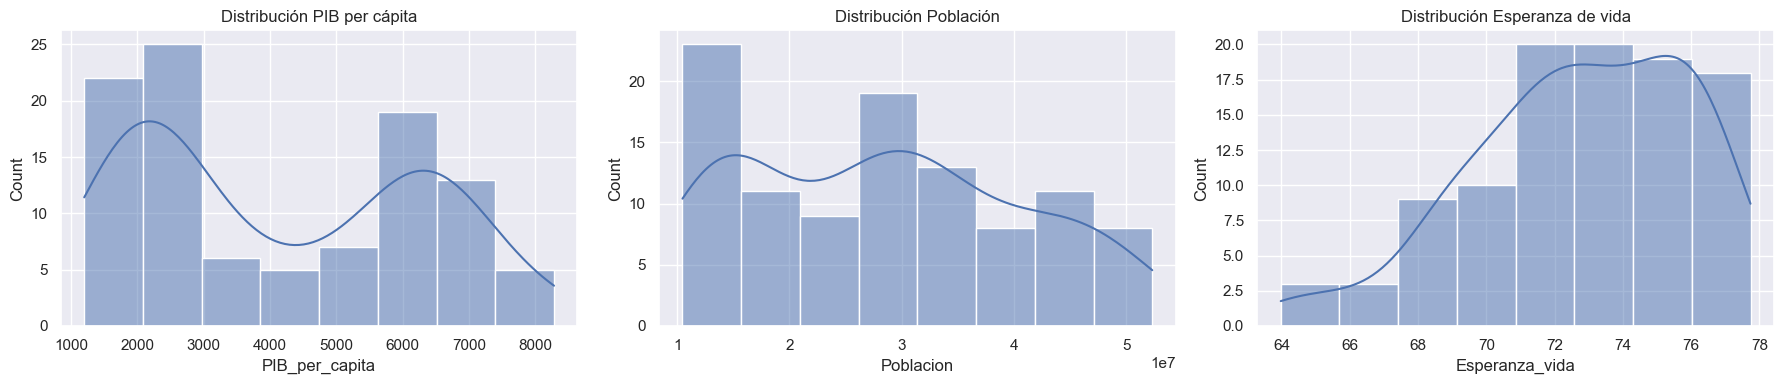

In [7]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(df["PIB_per_capita"], kde=True, ax=axes[0])
axes[0].set_title("Distribución PIB per cápita")

sns.histplot(df["Poblacion"], kde=True, ax=axes[1])
axes[1].set_title("Distribución Población")

sns.histplot(df["Esperanza_vida"], kde=True, ax=axes[2])
axes[2].set_title("Distribución Esperanza de vida")

plt.tight_layout()
plt.show()


##  8. Boxplots — Identificación de outliers

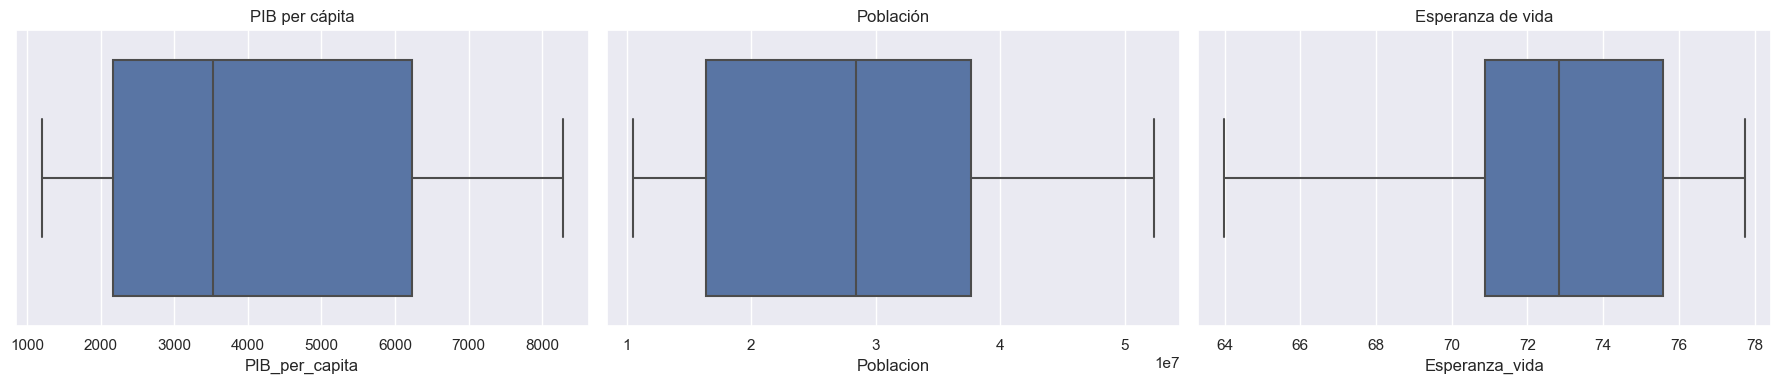

In [8]:

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(x=df["PIB_per_capita"], ax=axes[0])
sns.boxplot(x=df["Poblacion"], ax=axes[1])
sns.boxplot(x=df["Esperanza_vida"], ax=axes[2])

axes[0].set_title("PIB per cápita")
axes[1].set_title("Población")
axes[2].set_title("Esperanza de vida")

plt.tight_layout()
plt.show()


##  9. Matriz de correlación

In [9]:

corr = df[["PIB_per_capita", "Poblacion", "Esperanza_vida", "PIB_total"]].corr()
corr


,PIB_per_capita,Poblacion,Esperanza_vida,PIB_total
PIB_per_capita,1.000000,0.397342,0.827216,0.830778
Poblacion,0.397342,1.000000,0.207592,0.789769
Esperanza_vida,0.827216,0.207592,1.000000,0.619091
PIB_total,0.830778,0.789769,0.619091,1.000000


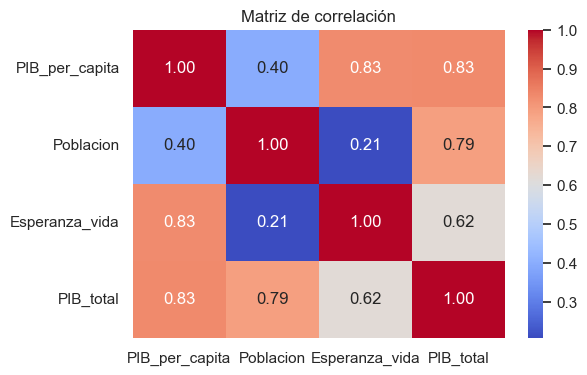

In [10]:

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


## 10. Serie de tiempo del PIB per cápita (1990–2023)

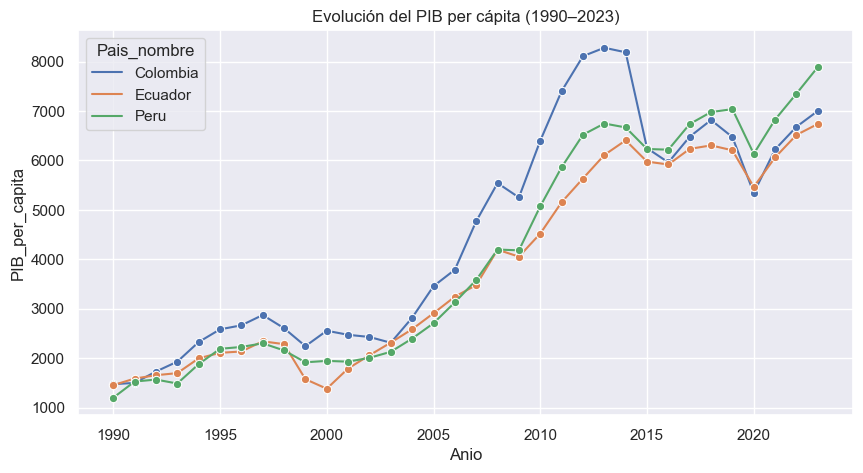

In [11]:

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x="Anio", y="PIB_per_capita", hue="Pais_nombre", marker="o")
plt.title("Evolución del PIB per cápita (1990–2023)")
plt.show()


##  11. Relación Esperanza de vida vs PIB per cápita

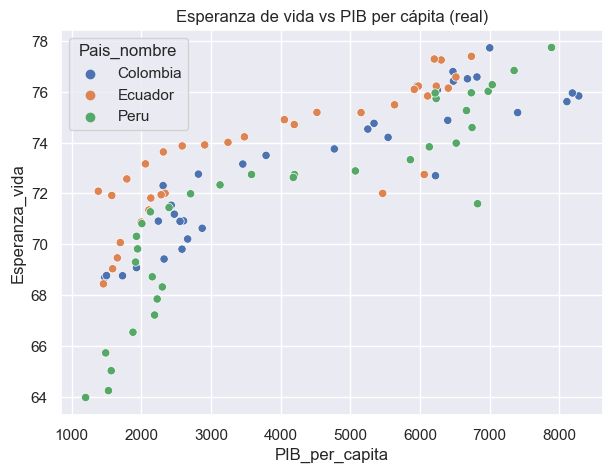

In [12]:

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="PIB_per_capita", y="Esperanza_vida", hue="Pais_nombre")
plt.title("Esperanza de vida vs PIB per cápita (real)")
plt.show()


##  12. Prueba de normalidad — Shapiro-Wilk

In [13]:

muestra = df["PIB_per_capita"].dropna().sample(50, random_state=42)

stat, p = shapiro(muestra)
print("Estadístico Shapiro-Wilk:", stat)
print("p-valor:", p)


Estadístico Shapiro-Wilk: 0.8823674917221069
p-valor: 0.0001321231247857213


##  13. Correlación de Pearson (PIB vs Esperanza de vida)

In [14]:

corr_val, p_val = pearsonr(df["PIB_per_capita"], df["Esperanza_vida"])
print("Correlación:", corr_val)
print("p-valor:", p_val)


Correlación: 0.8272160281395798
p-valor: 8.829979055389134e-27



---
#  Ejercicios sugeridos

1. Calcular la media, mediana y desviación estándar de la **esperanza de vida por país**.  
2. Analizar el crecimiento promedio del **PIB per cápita** entre 1990–2023.  
3. Crear boxplot del **PIB per cápita por país**.  
4. Calcular correlación entre **Población** y **PIB_total**.  
5. Extender el análisis añadiendo un cuarto país: **Chile (CHL)**.

---
